In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import xgboost as xgb

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = pd.read_csv("./drive/My Drive/Datasets/UNSW-Specific/DoS_TCP.csv",sep=';',float_precision='high')

In [0]:
data

,stime,flgs,proto,saddr,sport,dir,daddr,dport,pkts,bytes,state,srcid,ltime,seq,dur,mean,stddev,smac,dmac,sum,min,max,soui,doui,sco,dco,spkts,dpkts,sbytes,dbytes,rate,srate,drate,record,attack,category,subcategory
0,1.528081e+09,e,udp,192.168.100.46,3456.0,<->,192.168.100.5,80.0,14710,14308316,CON,0.0.0.0,1.528081e+09,1,91.996368,4.829252,0.683329,NaN,NaN,91.755783,1.930183,4.999841,NaN,NaN,NaN,NaN,7355,7355,6987961,7320355,159.886749,79.937935,79.937935,,0,Normal,Normal
1,1.528081e+09,e *,tcp,192.168.100.55,8080.0,<?>,192.168.100.3,80.0,14710,14335636,CON,0.0.0.0,1.528081e+09,2,91.996353,4.829021,0.683285,NaN,NaN,91.751396,1.930169,4.999833,NaN,NaN,NaN,NaN,7355,7355,7397914,6937722,159.886780,79.937950,79.937950,,0,Normal,Normal
2,1.528081e+09,e,udp,192.168.100.46,80.0,->,192.168.100.5,80.0,7355,7056880,INT,0.0.0.0,1.528081e+09,3,91.996353,4.826247,0.693380,NaN,NaN,91.698685,1.884608,4.999891,NaN,NaN,NaN,NaN,7355,0,7056880,0,79.937950,79.937950,0.000000,,0,Normal,Normal
3,1.528081e+09,e,tcp,192.168.100.6,80.0,?>,192.168.100.3,80.0,2482,734672,CON,0.0.0.0,1.528081e+09,5,91.971352,4.804359,0.700877,NaN,NaN,91.282822,1.831126,4.998389,NaN,NaN,NaN,NaN,2482,0,734672,0,26.975792,26.975792,0.000000,,0,Normal,Normal
4,1.528081e+09,e,tcp,192.168.100.46,80.0,?>,192.168.100.5,80.0,7355,6885400,CON,0.0.0.0,1.528081e+09,4,91.996353,4.826048,0.693337,NaN,NaN,91.694908,1.884595,4.999897,NaN,NaN,NaN,NaN,7355,0,6885400,0,79.937950,79.937950,0.000000,,0,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12316600,1.528084e+09,e,tcp,192.168.100.5,0.0,?>,192.168.100.3,0.0,2180,1549378,CON,0.0.0.0,1.528084e+09,3,45.416824,4.519526,1.371282,NaN,NaN,45.195259,0.405684,4.977525,NaN,NaN,NaN,NaN,2180,0,1549378,0,47.977814,47.977814,0.000000,,0,Normal,Normal
12316601,1.528084e+09,e,udp,192.168.100.7,365.0,->,192.168.100.3,565.0,1954,117240,INT,0.0.0.0,1.528084e+09,4,45.416824,4.519826,1.371382,NaN,NaN,45.198265,0.405684,4.979401,NaN,NaN,NaN,NaN,1954,0,117240,0,43.001686,43.001686,0.000000,,0,Normal,Normal
12316602,1.528084e+09,e *,tcp,192.168.100.55,8080.0,<?>,192.168.100.3,80.0,7264,7079417,CON,0.0.0.0,1.528084e+09,5,45.404404,4.529309,1.378675,NaN,NaN,45.293087,0.393286,4.990774,NaN,NaN,NaN,NaN,3632,3632,3654628,3424789,159.962463,79.970215,79.970215,,0,Normal,Normal
12316603,1.528084e+09,e,udp,192.168.100.46,80.0,->,192.168.100.5,80.0,3632,3482290,INT,0.0.0.0,1.528084e+09,6,45.404404,4.529302,1.378672,NaN,NaN,45.293015,0.393288,4.990774,NaN,NaN,NaN,NaN,3632,0,3482290,0,79.970215,79.970215,0.000000,,0,Normal,Normal


In [0]:
data.drop(['dir','srcid','smac','dmac','soui','doui','sco','dco','record'],axis=1,inplace=True)

In [0]:
del data_yr

In [0]:
#Fixing python curse of floating numbers
data['ltimeSTR'] = round(data['ltime'],0).astype(str)

In [0]:
#Finally I found on stackoverflow how to do this thing, spending for whole month (or several months)
test = data.iloc[:5000].groupby(['saddr','ltimeSTR'])['bytes'].transform(lambda x:x.rolling(100,1).count())
test

0         1
1         1
2         2
3         1
4         3
       ... 
4995    100
4996    100
4997    100
4998    100
4999    100
Name: bytes, Length: 5000, dtype: int64

In [0]:
#generating additional features
data['N_IN_Conn_P_SrcIP'] = data.groupby(['saddr','ltimeSTR'])['bytes'].transform(lambda x:x.rolling(100,1).count())
data['N_IN_Conn_P_DstIP'] = data.groupby(['daddr','ltimeSTR'])['bytes'].transform(lambda x:x.rolling(100,1).count())


In [0]:
data.head()

,stime,flgs,proto,saddr,sport,daddr,dport,pkts,bytes,state,ltime,seq,dur,mean,stddev,sum,min,max,spkts,dpkts,sbytes,dbytes,rate,srate,drate,attack,category,subcategory,ltimeSTR,N_IN_Conn_P_SrcIP,N_IN_Conn_P_DstIP
0,1.528081e+09,e,udp,192.168.100.46,3456.0,192.168.100.5,80.0,14710,14308316,CON,1.528081e+09,1,91.996368,4.829252,0.683329,91.755783,1.930183,4.999841,7355,7355,6987961,7320355,159.886749,79.937935,79.937935,0,Normal,Normal,1528081356.0,1,1
1,1.528081e+09,e *,tcp,192.168.100.55,8080.0,192.168.100.3,80.0,14710,14335636,CON,1.528081e+09,2,91.996353,4.829021,0.683285,91.751396,1.930169,4.999833,7355,7355,7397914,6937722,159.886780,79.937950,79.937950,0,Normal,Normal,1528081356.0,1,1
2,1.528081e+09,e,udp,192.168.100.46,80.0,192.168.100.5,80.0,7355,7056880,INT,1.528081e+09,3,91.996353,4.826247,0.693380,91.698685,1.884608,4.999891,7355,0,7056880,0,79.937950,79.937950,0.000000,0,Normal,Normal,1528081356.0,2,2
3,1.528081e+09,e,tcp,192.168.100.6,80.0,192.168.100.3,80.0,2482,734672,CON,1.528081e+09,5,91.971352,4.804359,0.700877,91.282822,1.831126,4.998389,2482,0,734672,0,26.975792,26.975792,0.000000,0,Normal,Normal,1528081356.0,1,2
4,1.528081e+09,e,tcp,192.168.100.46,80.0,192.168.100.5,80.0,7355,6885400,CON,1.528081e+09,4,91.996353,4.826048,0.693337,91.694908,1.884595,4.999897,7355,0,6885400,0,79.937950,79.937950,0.000000,0,Normal,Normal,1528081356.0,3,3


In [0]:
#caching Test
data.to_pickle("./drive/My Drive/Datasets/UNSW-Specific/Cache/DoS_Tcp.pkl")

In [0]:
#loading cache test
data = pd.read_pickle("./drive/My Drive/Datasets/UNSW-Specific/Cache/Service_Scan.pkl")

In [0]:
data.drop(['stime','flgs','ltime','pkts','bytes','dur','sum','spkts','dpkts','sbytes','dbytes','rate','category','subcategory','ltimeSTR'],axis=1,inplace=True)

In [0]:
#StateConverter
from collections import defaultdict
knownstatemap = {'RST':1,'CON':2,'REQ':3,'INT':4,'URP':5,'FIN':6,'ACC':7,'NRS':8,'ECO':9,'TST':10,'MAS':11}
statemap = defaultdict(lambda: "0", knownstatemap)
data['state']=data['state'].map(statemap)

In [0]:
data = data[['proto', 'saddr', 'sport', 'daddr', 'dport', 'state', 'seq', 'mean', 'stddev', 'min', 'max', 'srate', 'drate', 'N_IN_Conn_P_SrcIP', 'N_IN_Conn_P_DstIP','attack']]

In [0]:
data.drop(['seq','stddev'],axis=1,inplace=True)#get rid of useless features

In [0]:
#Oversampling data
data_x,data_y = data.iloc[:,5:-1],data.iloc[:,-1]

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
data_xr,data_yr = ros.fit_resample(data_x,data_y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
#split train/test Data
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(data_xr,data_yr, train_size=0.75,random_state=5)

In [0]:
test_x

array([[2, 0.000138, 0.000138, ..., 0.0, 1, 1],
       [2, 0.007323, 0.007323, ..., 0.0, 1, 1],
       [4, 0.0, 0.0, ..., 0.0, 1, 1],
       ...,
       [1, 0.000841, 0.000841, ..., 0.0, 100, 100],
       [1, 2.1e-05, 2.1e-05, ..., 0.0, 1, 3],
       [2, 4.947291, 1.348159, ..., 20.161507, 3, 3]], dtype=object)

In [0]:
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
scaler = preprocessing.MinMaxScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [0]:
#train_x,train_y = SMOTE().fit_resample(train_x, train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
#TRAIN!!
#from sklearn.naive_bayes import GaussianNB
#from sklearn.ensemble import RandomForestClassifier
#model = RandomForestClassifier(max_depth=6, random_state=0,n_estimators=120)
#model.fit(train_x, train_y)  


In [0]:
#TRAIN!!
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(8, input_dim=8, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(70, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(90, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_x, train_y, epochs=4, batch_size=100)

Epoch 1/4
2195046/2195046 [==============================] - 50s 23us/step - loss: 0.0401 - accuracy: 0.9881
Epoch 2/4
2195046/2195046 [==============================] - 50s 23us/step - loss: 0.0317 - accuracy: 0.9903
Epoch 3/4
2195046/2195046 [==============================] - 50s 23us/step - loss: 0.0302 - accuracy: 0.9907
Epoch 4/4
2195046/2195046 [==============================] - 50s 23us/step - loss: 0.0296 - accuracy: 0.9907


In [0]:
%timeit result_y = model.predict_classes(test_x[1].reshape(1,8))

The slowest run took 85.93 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 658 µs per loop


In [0]:
model.predict_proba(test_x[90].reshape(1,8))

array([[1.]], dtype=float32)

In [0]:
result_yt = model.predict_proba(test_x)

In [0]:
result_yt

array([[3.9875805e-03],
       [5.4514408e-04],
       [2.2459388e-02],
       ...,
       [1.0000000e+00],
       [1.0000000e+00],
       [4.4213738e-07]], dtype=float32)

In [0]:
result_yta = np.where(result_yt >= 0.5,1,0)
result_yta

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [0]:
from sklearn import metrics
ACR= metrics.accuracy_score(test_y,result_yta)
PRC= metrics.precision_score(test_y,result_yta)
RCL= metrics.recall_score(test_y,result_yta)
print('Accuracy = ' + "{:.4f}".format(ACR))
print('Precision = ' + "{:.4f}".format(PRC))
print('Recall = ' + "{:.4f}".format(RCL))
cm=metrics.confusion_matrix(test_y,result_yta)

Accuracy = 0.9906
Precision = 0.9945
Recall = 0.9866


In [0]:
cm

array([[364696,   1995],
       [  4895, 360096]])

In [0]:
sumTest = np.sum(test_y==0),np.sum(test_y==1)
sumTrain = np.sum(train_y==0),np.sum(train_y==1)
print(*sumTrain)
print(sum(sumTrain))
print(*sumTest)
print(sum(sumTest))

9237903 9236092
18473995
3078094 3079905
6157999


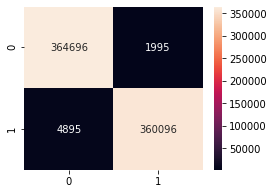

In [0]:
plt.figure(figsize=(4,3))
cmplot = sns.heatmap(cm, annot=True,fmt="d")

In [0]:
import joblib
joblib.dump(scaler, 'minmax_Keras_TcpF1-8F.jlb') 

['minmax_Keras_TcpF1-8F.jlb']

In [0]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                330       
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_5 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_6 (Dense)              (None, 70)                4270      
_________________________________________________________________
dense_7 (Dense)              (None, 80)               

In [0]:
#ROC
from sklearn.metrics import roc_curve,auc
yp = result_yt.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_y, yp)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

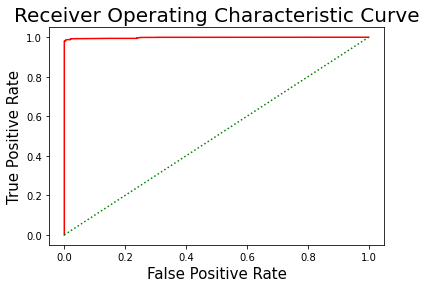

In [0]:
plt.plot(fpr_keras,tpr_keras, color='red')
plt.title('Receiver Operating Characteristic Curve', size=20)
plt.plot([0, 1], [0, 1], color='green', linestyle=':')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.show()


In [0]:
model.save('TCP_Keras_8F_9L.h5')